In [30]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/gdal"
os.environ["PROJ_LIB"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
os.environ["PROJ_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
import ee
import h5py
import pickle
import math
import datetime
import requests
import traceback
import shapely
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime 
from datetime import timedelta
from datetime import timezone
import time
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5
from lakeanalysis.nsidc import download_is2, read_atl03

In [2]:
out_path_csv = 'data/lakestats_methods_paper.csv'
df_stats = pd.read_csv(out_path_csv)

In [93]:
def sf3(f):
    return str(int(f)) if str(f).find('.')>3 else f"{f:.3g}"

def set_axis_color(ax, axcolor):
    ax.spines['bottom'].set_color(axcolor)
    ax.spines['top'].set_color(axcolor) 
    ax.spines['right'].set_color(axcolor)
    ax.spines['left'].set_color(axcolor)
    ax.tick_params(axis='x', colors=axcolor)
    ax.tick_params(axis='y', colors=axcolor)
    ax.yaxis.label.set_color(axcolor)
    ax.xaxis.label.set_color(axcolor)
    ax.title.set_color(axcolor)

from matplotlib.patches import Patch
def style_legend_titles_by_removing_handles(leg: matplotlib.legend.Legend) -> None:
    for col in leg._legend_handle_box.get_children():
        row = col.get_children()
        new_children: list[plt.Artist] = []
        for hpacker in row:
            if not isinstance(hpacker, matplotlib.offsetbox.HPacker):
                new_children.append(hpacker)
                continue
            drawing_area, text_area = hpacker.get_children()
            handle_artists = drawing_area.get_children()
            if not all(a.get_visible() for a in handle_artists):
                new_children.append(text_area)
            else:
                new_children.append(hpacker)
        col._children = new_children

def flatness_check(imf, df, dfm, axs=None, ax_color='k', ax_lab='', plot=False, normalize_to_zero=False, legendtitle=True):

    # def set_axis_color(ax, axcolor):
    #     ax.spines['bottom'].set_color(axcolor)
    #     ax.spines['top'].set_color(axcolor) 
    #     ax.spines['right'].set_color(axcolor)
    #     ax.spines['left'].set_color(axcolor)
    #     ax.tick_params(axis='x', colors=axcolor)
    #     ax.tick_params(axis='y', colors=axcolor)
    #     ax.yaxis.label.set_color(axcolor)
    #     ax.xaxis.label.set_color(axcolor)
    #     ax.title.set_color(axcolor)
        
    mf = dfm.iloc[imf].name
    dfseg = df[df.mframe==mf].copy()
    dfseg.xatc -= dfseg.xatc.min()
    
    bin_height_coarse=0.2
    bin_height_fine=0.01
    smoothing_histogram=0.1
    buffer=2.0
    width_surf=0.12
    width_buff=0.35
    rel_dens_upper_thresh=5
    rel_dens_lower_thresh=2
    min_phot=30
    min_snr_surface=10
    min_snr_vs_all_above=100
    
    promininece_threshold = 0.1
    bins_coarse1 = np.arange(start=dfseg.h.min(), stop=dfseg.h.max(), step=bin_height_coarse)
    hist_mid1 = bins_coarse1[:-1] + 0.5 * bin_height_coarse
    broad_hist = np.array(pd.Series(np.histogram(dfseg.h, bins=bins_coarse1)[0]).rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=2.5))
    broad_hist /= np.max(broad_hist)
    peaks, peak_props = find_peaks(broad_hist, height=promininece_threshold, distance=1.0, prominence=promininece_threshold)
    peak_hs = hist_mid1[peaks]
    if len(peaks) > 1:
        peak_proms = peak_props['prominences']
        idx_2highest = np.flip(np.argsort(peak_proms))[:2]
        pks_h = np.sort(peak_hs[idx_2highest])
        peak_loc1 = np.max(pks_h)
    else:
        peak_loc1 = hist_mid1[np.argmax(broad_hist)]
    
    # decrease bin width and find finer peak
    bins_coarse2 = np.arange(start=peak_loc1-buffer, stop=peak_loc1+buffer, step=bin_height_fine)
    hist_mid2 = bins_coarse2[:-1] + 0.5 * bin_height_fine
    hist = np.histogram(dfseg.h, bins=bins_coarse2)
    window_size = int(smoothing_histogram/bin_height_fine)
    hist_vals = hist[0] / np.max(hist[0])
    hist_vals_smoothed = np.array(pd.Series(hist_vals).rolling(window=window_size*3, center=True, min_periods=1, win_type='gaussian').mean(std=window_size/2))
    hist_vals_smoothed /= np.max(hist_vals_smoothed)
    peak_loc2 = hist_mid2[np.argmax(hist_vals_smoothed)]
    
    hist_vals_smoothed1 = np.array(pd.Series(hist_vals).rolling(window_size,center=True,min_periods=1).mean())
    hist_vals_smoothed1 /= np.max(hist_vals_smoothed1)
    
    # calculate relative photon densities
    peak_upper = peak_loc2 + width_surf
    peak_lower = peak_loc2 - width_surf
    above_upper = peak_upper + width_buff
    below_lower = peak_lower - width_buff
    sum_peak = np.sum((dfseg.h > peak_lower) & (dfseg.h < peak_upper))
    sum_above = np.sum((dfseg.h > peak_upper) & (dfseg.h < above_upper))
    sum_below = np.sum((dfseg.h > below_lower) & (dfseg.h < peak_lower))
    sum_all_above = np.sum(dfseg.h > peak_upper)
    h_range_all_above = np.max((dfseg.h.max() - peak_upper, 10.0))
    noise_rate_all_above = sum_all_above / h_range_all_above
    signal_rate = sum_peak / (width_surf*2)
    rel_dens_upper = 1000 if sum_above==0 else signal_rate / (sum_above / width_buff)
    rel_dens_lower = 1000 if sum_below==0 else signal_rate / (sum_below / width_buff)
    noise_rate = (dfseg.h.count() - sum_peak) / (dfseg.h.max() - dfseg.h.min() - width_surf*2)
    snr_surface = signal_rate / noise_rate
    snr_allabove = 1000 if noise_rate_all_above == 0 else signal_rate / noise_rate_all_above
    
    len_x = dfseg.xatc.max() - dfseg.xatc.min()
    h_range_no_surf = np.max((dfseg.h.max() - dfseg.h.min() - width_surf*2, 20.0))
    sum_no_surf = dfseg.h.count() - sum_peak
    d_surf = sum_peak / (width_surf*2 * len_x)
    d_1 = sum_below / (width_buff * len_x)
    d_2 = sum_above / (width_buff * len_x)
    d_3 = sum_no_surf / (h_range_no_surf * len_x)
    d_4 = sum_all_above / (h_range_all_above * len_x)
    
    is_flat_like_lake = (rel_dens_upper > rel_dens_upper_thresh) \
                        & (rel_dens_lower > rel_dens_lower_thresh) \
                        & (snr_surface > min_snr_surface) \
                        & (snr_allabove > min_snr_vs_all_above)

    yl_return = ((peak_loc2-1.5, peak_loc2+1.5))

    if plot:
        if not axs: 
            fig, axs = plt.subplots(figsize=[6, 8], dpi=100, ncols=2, sharey=True)

        if normalize_to_zero:
            yl = np.array(yl_return) - peak_loc2
            peak_lower -= peak_loc2
            peak_upper -= peak_loc2
            below_lower -= peak_loc2
            above_upper -= peak_loc2
            dfseg.h -= peak_loc2
            hist_mid2 -= peak_loc2
            peak_loc2 = 0
            
    
        col_peak = 'gray'
        col_above = 'b'
        col_below = 'c'
        col_allabove = 'r'
        col_no_surf = 'y'
        
        box_alph = 0.3
        ax = axs[0]
        xl = [dfseg.xatc.min(), dfseg.xatc.max()]
        ax.fill_between(x=xl, y1=peak_lower, y2=peak_upper, color=col_peak, alpha=box_alph)
        ax.fill_between(x=xl, y1=below_lower, y2=peak_lower, facecolor="none", hatch='----', edgecolor=col_below, linewidth=0.0, alpha=box_alph)
        ax.fill_between(x=xl, y1=peak_upper, y2=above_upper, facecolor="none", hatch='|||', edgecolor=col_above, linewidth=0.0, alpha=box_alph)
        ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, linewidth=0.0, alpha=box_alph)
        ax.fill_between(x=xl, y1=yl[0], y2=peak_lower, facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, linewidth=0.0, alpha=box_alph)
        ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='///', edgecolor=col_allabove, linewidth=0.0, alpha=box_alph)
        ax.scatter(dfseg.xatc, dfseg.h, s=4, alpha=1, facecolors='k', edgecolors='none')
        ax.plot(xl, [peak_loc2]*2, 'r-')
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        # ax.set_ylabel('elevation (m)')
        ax.set_xlabel('along-track distance (m)')
        set_axis_color(ax, ax_color)
        ax.text(0.03, 0.98, r'\textbf{%s}' % ax_lab, transform=ax.transAxes, color=ax_color, ha='left', va='top', fontsize=12, bbox=boxprops)
        
        ax = axs[1]
        xl = [0,1]
        dens0 = ax.fill_between(x=xl, y1=peak_lower, y2=peak_upper, color=col_peak, alpha=box_alph,
                           label='$d_0 = %.2g$ photons/m$^2$' % d_surf)
        # y1=below_lower, y2=peak_lower
        # y1=peak_upper, y2=above_upper
        # y1=peak_upper, y2=yl[1]
        # y1=yl[0], y2=peak_lower
        # y1=peak_upper, y2=yl[1]
        
        dens1 = ax.fill_between(x=xl, y1=below_lower, y2=peak_lower, facecolor="none", hatch='----', edgecolor=col_below, 
                                linewidth=0.0, alpha=box_alph, label='$d_1 = %.2g$ photons/m$^2$' % d_1)
        dens2 = ax.fill_between(x=xl, y1=peak_upper, y2=above_upper, facecolor="none", hatch='|||', edgecolor=col_above, 
                                linewidth=0.0, alpha=box_alph, label='$d_2 = %.2g$ photons/m$^2$' % d_2)
        dens3 = ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, 
                                linewidth=0.0, alpha=box_alph, label='$d_3 = %.2g$ photons/m$^2$' % d_3)
        ax.fill_between(x=xl, y1=yl[0], y2=peak_lower, facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, 
                        linewidth=0.0, alpha=box_alph)
        dens4 = ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='///', edgecolor=col_allabove, 
                                linewidth=0.0, alpha=box_alph, label='$d_4 = %.2g$ photons/m$^2$' % d_4)
        
        surf, = ax.plot(xl, [peak_loc2]*2, 'r-', label='photon density peak')
        dens, = ax.plot(hist_vals_smoothed, hist_mid2, 'k-', label='photon density')
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.set_xlabel('normalized density')
        set_axis_color(ax, ax_color)

        # print('\n', imf)
        # print('sum_peak:     ', sum_peak)
        # print('sum_below:    ', sum_below)
        # print('sum_above:    ', sum_above)
        # print('sum_no_surf:  ', sum_no_surf)
        # print('sum_all_above:', sum_all_above)
        # print('width_surf:       ', width_surf)
        # print('width_buff:       ', width_buff)
        # print('h_range_no_surf:  ', h_range_no_surf)
        # print('h_range_all_above:', h_range_all_above)
        # print('d_surf:', d_surf)
        # print('d_1:', d_1)
        # print('d_2:', d_2)
        # print('d_3:', d_3)
        # print('d_4:', d_4)
        # print('rel_dens_lower', rel_dens_lower, '>', rel_dens_lower_thresh)
        # print('rel_dens_upper', rel_dens_upper, '>', rel_dens_upper_thresh)
        # print('snr_surface', snr_surface, '>', min_snr_surface)
        # print('snr_allabove', snr_allabove, '>', min_snr_vs_all_above)
        # print(d_surf/d_1)
        # print(d_surf/d_2)
        # print(d_surf/d_3)
        # print(d_surf/d_4)
        # print('is flat:', is_flat_like_lake)

        r_1 = d_surf/d_1
        r_2 = d_surf/d_2
        r_3 = d_surf/d_3
        r_4 = d_surf/d_4

        s1 = '>' if r_1>rel_dens_lower_thresh else '<'
        s2 = '>' if r_2>rel_dens_upper_thresh else '<'
        s3 = '>' if r_3>min_snr_surface else '<'
        s4 = '>' if r_4>min_snr_vs_all_above else '<'

        p1 = 'pass' if r_1>rel_dens_lower_thresh else 'fail'
        p2 = 'pass' if r_2>rel_dens_upper_thresh else 'fail'
        p3 = 'pass' if r_3>min_snr_surface else 'fail'
        p4 = 'pass' if r_4>min_snr_vs_all_above else 'fail'

        # r1 = ax.scatter(0,0,alpha=0, label=r'$d_0/d_1 = %s %s %g \Rightarrow$ %s' % (sf3(r_1),s1,rel_dens_lower_thresh,p1))
        # r2 = ax.scatter(0,0,alpha=0, label=r'$d_0/d_2 = %s %s %g \Rightarrow$ %s' % (sf3(r_2),s2,rel_dens_upper_thresh,p2))
        # r3 = ax.scatter(0,0,alpha=0, label=r'$d_0/d_3 = %s %s %g \Rightarrow$ %s' % (sf3(r_3),s3,min_snr_surface,p3))
        # r4 = ax.scatter(0,0,alpha=0, label=r'$d_0/d_4 = %s %s %g \Rightarrow$ %s' % (sf3(r_4),s4,min_snr_vs_all_above,p4))
        r1 = Patch(visible=False, label=r'$d_0/d_1 = %s %s %g \Rightarrow$ %s' % (sf3(r_1),s1,rel_dens_lower_thresh,p1))
        r2 = Patch(visible=False, label=r'$d_0/d_2 = %s %s %g \Rightarrow$ %s' % (sf3(r_2),s2,rel_dens_upper_thresh,p2))
        r3 = Patch(visible=False, label=r'$d_0/d_3 = %s %s %g \Rightarrow$ %s' % (sf3(r_3),s3,min_snr_surface,p3))
        r4 = Patch(visible=False, label=r'$d_0/d_4 = %s %s %g \Rightarrow$ %s' % (sf3(r_4),s4,min_snr_vs_all_above,p4))
    
        ax = axs[2]
        hdls = [dens, surf, dens0, dens1, dens2, dens3, dens4, r1, r2, r3, r4]
        
        # is_pass = 'passes' if is_flat_like_lake else 'does not pass'
        # tit = 'major frame %s\nflatness check' % is_pass
        if is_flat_like_lake:
            tit = 'major frame %s passes\nflatness check' % ax_lab
        else:
            tit = 'major frame %s does not\npass flatness check' % ax_lab
        if legendtitle:
            leg = ax.legend(handles=hdls, fontsize=7, loc='center', title=tit, framealpha=0.3)
            frame = leg.get_frame()
            frame.set_edgecolor(ax_color)
        else:
            leg = ax.legend(handles=hdls, fontsize=7, loc='center', framealpha=0.3)
            frame = leg.get_frame()
            frame.set_edgecolor('none')
        style_legend_titles_by_removing_handles(leg)

    return yl_return, is_flat_like_lake

68.93704621742532 -47.96565498988521
2019-07-12T05:29:26Z
ATL03_20190712052659_02160403_006_02.h5
216
gt1l


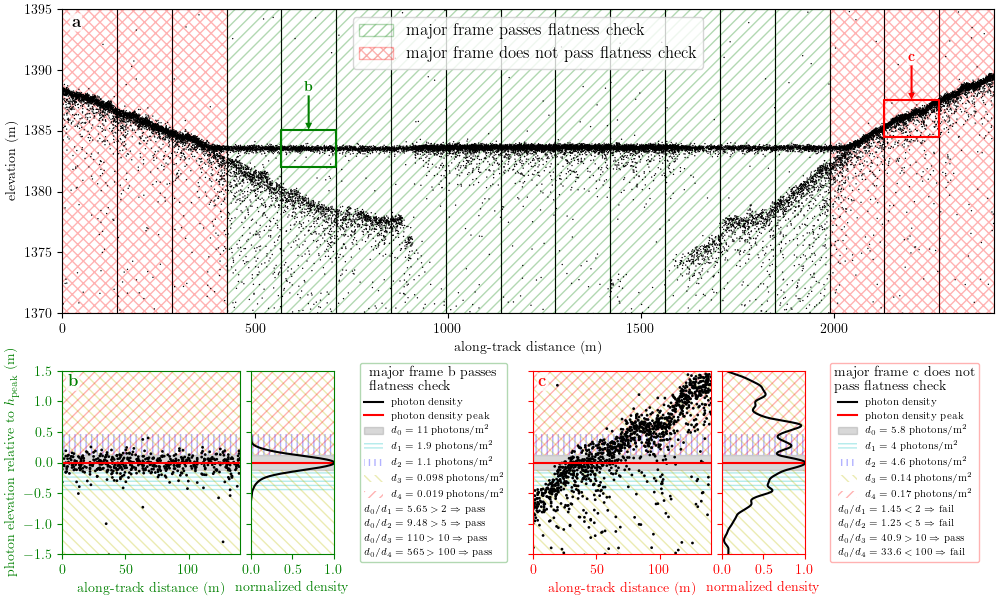

In [94]:
plt.close('all')

files = ['data/lakes/lake_08705379_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190712052659_02160403_006_02_gt1l_0000.h5',
         'data/lakes/lake_03588680_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190818034635_07800403_006_02_gt3l_0015.h5',
         'data/lakes/lake_07867606_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5'
        ]
ylms = [(1370, 1395),
        (1120, 1155),
        (1140, 1175)
       ]
imfs = [(4,15),
        (5,11),
        (13,1)
       ]

ilake = 0
file = files[ilake]
ylm = ylms[ilake]
iimf = imfs[ilake]
lk = dictobj(read_melt_lake_h5(file))

print(lk.lat, lk.lon)
print(lk.time_utc)
print(lk.granule_id)
print(lk.rgt)
print(lk.gtx)

df = lk.photon_data
dfm = lk.mframe_data

plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

fig = plt.figure(figsize=[10, 6], dpi=100)
gs = fig.add_gridspec(ncols=10, nrows=5)
axs = [fig.add_subplot(gs[:3, :])]
nrows = 2
for i in np.arange(nrows):
    axs.append(fig.add_subplot(gs[3:, 5*i:5*i+2]))
    if i==0:
        axs[-1].set_ylabel('elevation (m)')
    else:
        plt.setp(axs[-1].get_yticklabels(), visible=False)
    axs.append(fig.add_subplot(gs[3:, 5*i+2], sharey=axs[-1]))
    plt.setp(axs[-1].get_yticklabels(), visible=False)
    axs.append(fig.add_subplot(gs[3:, 5*i+3:5*i+5]))
    axs[-1].axis('off')

ax = axs[0]
ax.scatter(df.xatc, df.h, s=1, alpha=1, facecolors='k', edgecolors='none')
lns = []
for i in range(len(dfm)-1):
    ln = (dfm.iloc[i].xatc_max + dfm.iloc[i+1].xatc_min) / 2
    ax.plot([ln]*2, ylm, 'k-', lw=0.7)
    lns.append(ln)

bounds = [df.xatc.min()] + lns + [df.xatc.max()]
hdls = [0, 0]
for i in range(len(bounds)-1):
    thisylm, is_flat = flatness_check(imf=i, df=df, dfm=dfm)
    thiscol = 'g' if is_flat else 'r'
    thishatch = '///' if is_flat else 'XXX'
    label = 'major frame passes flatness check' if is_flat else 'major frame does not pass flatness check'
    j = 0 if is_flat else 1
    hdl = ax.fill_between([bounds[i], bounds[i+1]], ylm[0], ylm[1], facecolor="none", hatch=thishatch, edgecolor=thiscol, 
                                linewidth=1, alpha=0.3, label=label, zorder=-100)
    hdls[j] = hdl

ax.legend(handles=hdls, loc='upper center', fontsize=12)
ax.set_xlim((df.xatc.min(), df.xatc.max()))
ax.set_ylim(ylm)
ax.set_xlabel('along-track distance (m)')
ax.set_ylabel('elevation (m)')

boxprops = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none', pad=0.1)
ax_color = 'g'
imf = iimf[0]
yl, is_flat = flatness_check(imf=imf, df=df, dfm=dfm, axs=axs[1:4], ax_color=ax_color, ax_lab='b', plot=True, normalize_to_zero=True)
axs[0].plot([lns[i] for i in [imf-1,imf, imf, imf-1, imf-1]], [yl[i] for i in [0,0,1,1,0]], c=ax_color)
xarr = (lns[imf]+lns[imf-1])/2
ax.annotate(r'\textbf{b}', xy=(xarr, yl[1]), xytext=(xarr, yl[1]+3), ha='center', va='bottom', color='g', bbox=boxprops,
            arrowprops=dict(facecolor='g', shrink=0.01, width=1.5, headwidth=5, headlength=5, edgecolor='none'))
axs[1].set_ylabel(r'photon elevation relative to $h_\text{peak}$ (m)')

ax_color = 'r'
imf = iimf[1]
yl, is_flat = flatness_check(imf=imf, df=df, dfm=dfm, axs=axs[4:7], ax_color=ax_color, ax_lab='c', plot=True, normalize_to_zero=True)
axs[0].plot([lns[i] for i in [imf-1,imf, imf, imf-1, imf-1]], [yl[i] for i in [0,0,1,1,0]], c=ax_color)
xarr = (lns[imf]+lns[imf-1])/2
ax.annotate(r'\textbf{c}', xy=(xarr, yl[1]), xytext=(xarr, yl[1]+3), ha='center', va='bottom', color='r', bbox=boxprops,
            arrowprops=dict(facecolor='r', shrink=0.01, width=1.5, headwidth=5, headlength=5, edgecolor='none'))

axs[0].text(0.01, 0.98, r'\textbf{a}', transform=axs[0].transAxes, color='k', ha='left', va='top', fontsize=12, bbox=boxprops)
# axs[1].text(0.03, 0.98, r'\textbf{b}', transform=axs[1].transAxes, color='g', ha='left', va='top', fontsize=12, bbox=boxprops)
# axs[4].text(0.03, 0.98, r'\textbf{c}', transform=axs[4].transAxes, color='r', ha='left', va='top', fontsize=12, bbox=boxprops)

# fig.tight_layout(pad=0.1, h_pad=0.1, v_pad=0.1)
gs.tight_layout(fig, pad=0.3, w_pad=0.3)

plt.savefig('plots/flatness_check_%d.jpg' % ilake, dpi=600)

## add imagery
functions for that are below, run that cell first!

68.93704621742532 -47.96565498988521
2019-07-12T05:29:26Z
ATL03_20190712052659_02160403_006_02.h5
216
gt1l


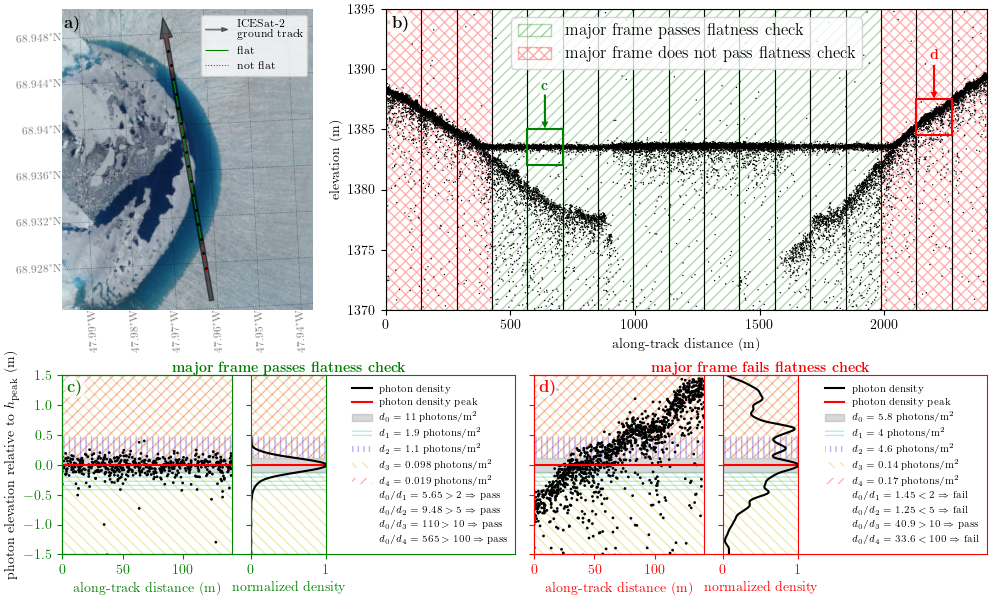

In [92]:
plt.close('all')

files = ['data/lakes/lake_08705379_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190712052659_02160403_006_02_gt1l_0000.h5',
         'data/lakes/lake_03588680_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190818034635_07800403_006_02_gt3l_0015.h5',
         'data/lakes/lake_07867606_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5'
        ]
ylms = [(1370, 1395),
        (1120, 1155),
        (1140, 1175)
       ]
imfs = [(4,15),
        (5,11),
        (13,1)
       ]

ilake = 0
file = files[ilake]
ylm = ylms[ilake]
iimf = imfs[ilake]
lk = dictobj(read_melt_lake_h5(file))

print(lk.lat, lk.lon)
print(lk.time_utc)
print(lk.granule_id)
print(lk.rgt)
print(lk.gtx)

df = lk.photon_data
dfm = lk.mframe_data

plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

fig = plt.figure(figsize=[10, 6], dpi=100)
gs = fig.add_gridspec(ncols=10, nrows=5)
ax0 = fig.add_subplot(gs[:3, :])
ax0.axis('off')

ax1 = ax0.inset_axes([-0.05, 0, 0.37, 1])
ax2 = ax0.inset_axes([0.35, 0, 0.65, 1])
axs = [ax1, ax2]
nrows = 2
for i in np.arange(nrows):
    axs.append(fig.add_subplot(gs[3:, 5*i:5*i+2]))
    if i==0:
        axs[-1].set_ylabel('elevation (m)')
    else:
        plt.setp(axs[-1].get_yticklabels(), visible=False)
    axs.append(fig.add_subplot(gs[3:, 5*i+2], sharey=axs[-1]))
    plt.setp(axs[-1].get_yticklabels(), visible=False)
    axs.append(fig.add_subplot(gs[3:, 5*i+3:5*i+5]))
    axs[-1].axis('off')

ax = axs[1]
ax.scatter(df.xatc, df.h, s=1, alpha=1, facecolors='k', edgecolors='none')
lns = []
for i in range(len(dfm)-1):
    ln = (dfm.iloc[i].xatc_max + dfm.iloc[i+1].xatc_min) / 2
    ax.plot([ln]*2, ylm, 'k-', lw=0.7)
    lns.append(ln)

bounds = [df.xatc.min()] + lns + [df.xatc.max()]
hdls = [0, 0]
is_flat_list = []
for i in range(len(bounds)-1):
    thisylm, is_flat = flatness_check(imf=i, df=df, dfm=dfm)
    is_flat_list.append(is_flat)
    thiscol = 'g' if is_flat else 'r'
    thishatch = '///' if is_flat else 'XXX'
    label = 'major frame passes flatness check' if is_flat else 'major frame does not pass flatness check'
    j = 0 if is_flat else 1
    hdl = ax.fill_between([bounds[i], bounds[i+1]], ylm[0], ylm[1], facecolor="none", hatch=thishatch, edgecolor=thiscol, 
                                linewidth=1, alpha=0.3, label=label, zorder=-100)
    hdls[j] = hdl

ax.legend(handles=hdls, loc='upper center', fontsize=12)
ax.set_xlim((df.xatc.min(), df.xatc.max()))
ax.set_ylim(ylm)
ax.set_xlabel('along-track distance (m)')
ax.set_ylabel('elevation (m)')

boxprops = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none', pad=0.1)
ax_color = 'g'
imf = iimf[0]
yl, is_flat = flatness_check(imf=imf, df=df, dfm=dfm, axs=axs[2:5], ax_color=ax_color, ax_lab='c)', plot=True, normalize_to_zero=True,
                            legendtitle=False)
axs[1].plot([lns[i] for i in [imf-1,imf, imf, imf-1, imf-1]], [yl[i] for i in [0,0,1,1,0]], c=ax_color)
xarr = (lns[imf]+lns[imf-1])/2
ax.annotate(r'\textbf{c}', xy=(xarr, yl[1]), xytext=(xarr, yl[1]+3), ha='center', va='bottom', color='g', bbox=boxprops,
            arrowprops=dict(facecolor='g', shrink=0.01, width=1.5, headwidth=5, headlength=5, edgecolor='none'))
axs[2].set_ylabel(r'photon elevation relative to $h_\text{peak}$ (m)', color='k')

ax_color = 'r'
imf = iimf[1]
yl, is_flat = flatness_check(imf=imf, df=df, dfm=dfm, axs=axs[5:8], ax_color=ax_color, ax_lab='d)', plot=True, normalize_to_zero=True,
                            legendtitle=False)
axs[1].plot([lns[i] for i in [imf-1,imf, imf, imf-1, imf-1]], [yl[i] for i in [0,0,1,1,0]], c=ax_color)
xarr = (lns[imf]+lns[imf-1])/2
ax.annotate(r'\textbf{d}', xy=(xarr, yl[1]), xytext=(xarr, yl[1]+3), ha='center', va='bottom', color='r', bbox=boxprops,
            arrowprops=dict(facecolor='r', shrink=0.01, width=1.5, headwidth=5, headlength=5, edgecolor='none'))


# axs[1].text(0.03, 0.98, r'\textbf{b}', transform=axs[1].transAxes, color='g', ha='left', va='top', fontsize=12, bbox=boxprops)
# axs[4].text(0.03, 0.98, r'\textbf{c}', transform=axs[4].transAxes, color='r', ha='left', va='top', fontsize=12, bbox=boxprops)


axpass = fig.add_subplot(gs[3:, :5])
axpass.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
axpass.patch.set_facecolor('none')
set_axis_color(axpass, 'green')
axpass.text(0.5, 1.02, r'\textbf{major frame passes flatness check}', ha='center', transform=axpass.transAxes, color='green')
axfail = fig.add_subplot(gs[3:, 5:])
axfail.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
axfail.patch.set_facecolor('none')
set_axis_color(axfail, 'red')
axfail.text(0.5, 1.02, r'\textbf{major frame fails flatness check}', ha='center', transform=axfail.transAxes, color='red')

#### add imagery
days_buffer=5
max_cloud_prob=15
gamma_value=1.0
imagery_filename=None
re_download=False
img_aspect=1.2
xlm = [None, None]
ylm = [None, None]

ax = axs[0]
ax.axis('off')

img, center_lon, center_lat = plot_imagery(fn=file, days_buffer=days_buffer, max_cloud_prob=max_cloud_prob, xlm=xlm, ylm=ylm, 
    gamma_value=gamma_value, imagery_filename=imagery_filename, re_download=re_download, ax=ax)

hdl_arr, hdls_ext = add_gt_to_imagery(file, img, ax, arrow_width=40, arrow_col=(0,0,0,0.5), arrow_ls='-', line_col='r', 
    arrow_label='ICESat-2\nground track', line_width=0.75, bounds=bounds, passing_list=is_flat_list, arrow_extend=0.15)
ax.legend(handles=[hdl_arr]+hdls_ext, loc='upper right', fontsize=8,
          handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow)})
        
if (img_aspect > 1): 
    h_rng = img.bounds.top - img.bounds.bottom
    cntr = (img.bounds.right + img.bounds.left) / 2
    ax.set_xlim(cntr-0.5*h_rng/img_aspect, cntr+0.5*h_rng/img_aspect)
elif img_aspect < 1: 
    w_rng = img.bounds.right - img.bounds.left
    cntr = (img.bounds.top + img.bounds.bottom) / 2
    ax.set_ylim(cntr-0.5*w_rng*img_aspect, cntr+0.5*w_rng/img_aspect)
            
add_graticule(img, ax)

axs[0].text(0.01, 0.98, r'\textbf{a)}', transform=axs[0].transAxes, color='k', ha='left', va='top', fontsize=12)
axs[1].text(0.01, 0.98, r'\textbf{b)}', transform=axs[1].transAxes, color='k', ha='left', va='top', fontsize=12, bbox=boxprops)

# fig.tight_layout(pad=0.1, h_pad=0.1, v_pad=0.1)
gs.tight_layout(fig, pad=0.3, w_pad=0.3)

plt.savefig('plots/flatness_check_imagery%d.jpg' % ilake, dpi=600)

# for ilake = 0 
# product_id: S2A_MSIL2A_20190713T150921_N0213_R025_T22WFB_20190713T191839
#     - time difference: 1 day, 2:44:04
#     - mean cloud probability: 7.9

In [85]:
#####################################################################
def add_gt_to_imagery(fn, img, ax, xlm=[None, None], arrow_width=20, arrow_col='k', arrow_ls='-', line_col='r', line_width=1, 
                      arrow_label=None, line_label=None, bounds=None, passing_list=None, arrow_extend=0):
    
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    dfd = lk.depth_data.copy()

    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if xlm[1] < 0:
        xlm[1] = df.xatc.max() + xlm[1]
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    dfd.xatc -= x_off
                          
    # df['x10'] = np.round(df.xatc, -1)
    df['x10'] = np.round(df.xatc)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().reset_index()
    ximg, yimg = warp.transform(src_crs='epsg:4326', dst_crs=img.crs, xs=np.array(gt.lon), ys=np.array(gt.lat))
    gt['ximg'] = ximg
    gt['yimg'] = yimg
    if not arrow_label:
        arrow_label = '%s (%s beam)' % (lk.gtx.upper(), lk.beam_strength)
    arr_xlen = ximg[-1]-ximg[0]
    arr_ylen = yimg[-1]-yimg[0]
    arr_xstart = ximg[0]
    arr_ystart = yimg[0]
    arr_xstart -= arr_xlen*arrow_extend/2
    arr_ystart -= arr_ylen*arrow_extend/2
    arr_xlen *= (1+arrow_extend)
    arr_ylen *= (1+arrow_extend)

    arrow_gt = ax.arrow(arr_xstart, arr_ystart, arr_xlen, arr_ylen, label=arrow_label, length_includes_head=True,
                        width=arrow_width, head_width=3*arrow_width, head_length=5*arrow_width, color=arrow_col, ls=arrow_ls, lw=1)
    
    if not passing_list:
        isdepth = dfd.depth>0
        bed = dfd.h_fit_bed
        bed[~isdepth] = np.nan
        bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
        surf = np.ones_like(dfd.xatc) * lk.surface_elevation
        surf[~isdepth] = np.nan
        xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
        lon_bed = np.array(dfd.lon)
        lat_bed = np.array(dfd.lat)
        lon_bed[(np.isnan(surf)) & (np.isnan(bed))] = np.nan
        lat_bed[(np.isnan(surf)) & (np.isnan(bed))] = np.nan
        xb, yb = warp.transform(src_crs='epsg:4326', dst_crs=img.crs, xs=lon_bed, ys=lat_bed)
        if not line_label:
            line_label = 'along-track lake extent'
        line_extent, = ax.plot(xb, yb, color=line_col, lw=line_width, zorder=5000, solid_capstyle='butt', label=line_label)
        hdls = [line_extent]
    elif bounds:
        hdls = [0, 0]
        is_flat_list = []
        for i, passes in enumerate(passing_list):
            minx = bounds[i]
            maxx = bounds[i+1]
            thiscol = 'g' if passes else 'r'
            label = 'flat' if passes else 'not flat'
            ls = '-' if passes else ':'
            j = 0 if passes else 1
            gtmf = gt[(gt.x10 >= minx) & (gt.x10 <= maxx)]
            hdl, = ax.plot(gtmf.ximg, gtmf.yimg, color=thiscol, lw=line_width, zorder=5000, solid_capstyle='butt', label=label, ls=ls)
            if (i < (len(passing_list)-1)) & (len(gtmf)>0):
                ax.scatter(gtmf.ximg.iloc[-1], gtmf.yimg.iloc[-1], s=1, color='k', zorder=6000)
            hdls[j] = hdl

    return arrow_gt, hdls

def make_legend_arrow(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
    return mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.5*height)

In [26]:
#####################################################################
def get_sentinel2_cloud_collection(area_of_interest, date_time, days_buffer):

    datetime_requested = datetime.strptime(date_time, '%Y-%m-%dT%H:%M:%SZ')
    start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    print('Looking for Sentinel-2 images from %s to %s' % (start_date, end_date), end=' ')

    # Import and filter S2 SR HARMONIZED
    s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Import and filter s2cloudless.
    s2_cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    cloud_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_collection,
        'secondary': s2_cloudless_collection,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    cloud_collection = cloud_collection.map(lambda img: img.addBands(ee.Image(img.get('s2cloudless')).select('probability')))

    def set_is2_cloudiness(img, aoi=area_of_interest):
        cloudprob = img.select(['probability']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                             geometry=aoi, 
                                                             bestEffort=True, 
                                                             maxPixels=1e6)
        return img.set('ground_track_cloud_prob', cloudprob.get('probability'))

    cloud_collection = cloud_collection.map(set_is2_cloudiness)

    return cloud_collection

    
#####################################################################
def download_imagery(fn, lk, gt, imagery_filename, days_buffer=5, max_cloud_prob=15, gamma_value=1.8, buffer_factor=1.2):

    lake_mean_delta_time = lk.mframe_data.dt.mean()
    ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc) # 2018-01-01:T00.00.00.000000 UTC, from ATL03 data dictionary 
    ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
    lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
    lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
    time_format_out = '%Y-%m-%dT%H:%M:%SZ'
    is2time = datetime.strftime(lake_mean_datetime, time_format_out)

    # get the bounding box
    lon_rng = gt.lon.max() - gt.lon.min()
    lat_rng = gt.lat.max() - gt.lat.min()
    fac = 0.25
    bbox = [gt.lon.min()-fac*lon_rng, gt.lat.min()-fac*lat_rng, gt.lon.max()+fac*lon_rng, gt.lat.max()+fac*lat_rng]
    poly = [(bbox[x[0]], bbox[x[1]]) for x in [(0,1), (2,1), (2,3), (0,3), (0,1)]]
    roi = ee.Geometry.Polygon(poly)

    # get the earth engine collection
    collection_size = 0
    if days_buffer > 200:
        days_buffer = 200
    increment_days = days_buffer
    while (collection_size<5) & (days_buffer <= 200):
    
        collection = get_sentinel2_cloud_collection(area_of_interest=roi, date_time=is2time, days_buffer=days_buffer)
    
        # filter collection to only images that are (mostly) cloud-free along the ICESat-2 ground track
        cloudfree_collection = collection.filter(ee.Filter.lt('ground_track_cloud_prob', max_cloud_prob))
        
        collection_size = cloudfree_collection.size().getInfo()
        if collection_size == 1: 
            print('--> there is %i cloud-free image.' % collection_size)
        elif collection_size > 1: 
            print('--> there are %i cloud-free images.' % collection_size)
        else:
            print('--> there are not enough cloud-free images: widening date range...')
        days_buffer += increment_days
    
        # get the time difference between ICESat-2 and Sentinel-2 and sort by it 
        is2time = lk.date_time
        def set_time_difference(img, is2time=is2time):
            timediff = ee.Date(is2time).difference(img.get('system:time_start'), 'second').abs()
            return img.set('timediff', timediff)
        cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')

    # create a region around the ground track over which to download data
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    gt_length = gt.x10.max() - gt.x10.min()
    point_of_interest = ee.Geometry.Point(lon_center, lat_center)
    region_of_interest = point_of_interest.buffer(gt_length*0.5*buffer_factor)

    if collection_size > 0:
        # select the first image, and turn the colleciton into an 8-bit RGB for download
        selectedImage = cloudfree_collection.first()
        mosaic = cloudfree_collection.sort('timediff', False).mosaic()
        rgb = mosaic.select('B4', 'B3', 'B2')
        rgb = rgb.unitScale(0, 10000).clamp(0.0, 1.0)
        rgb_gamma = rgb.pow(1/gamma_value)
        rgb8bit= rgb_gamma.multiply(255).uint8()
        
        # from the selected image get some stats: product id, cloud probability and time difference from icesat-2
        prod_id = selectedImage.get('PRODUCT_ID').getInfo()
        cld_prb = selectedImage.get('ground_track_cloud_prob').getInfo()
        s2datetime = datetime.fromtimestamp(selectedImage.get('system:time_start').getInfo()/1e3)
        s2datestr = datetime.strftime(s2datetime, '%Y-%b-%d')
        is2datetime = datetime.strptime(lk.date_time, '%Y-%m-%dT%H:%M:%SZ')
        timediff = s2datetime - is2datetime
        days_diff = timediff.days
        if days_diff == 0: diff_str = 'Same day as'
        if days_diff == 1: diff_str = '1 day after'
        if days_diff == -1: diff_str = '1 day before'
        if days_diff > 1: diff_str = '%i days after' % np.abs(days_diff)
        if days_diff < -1: diff_str = '%i days before' % np.abs(days_diff)
        
        print('--> Closest cloud-free Sentinel-2 image:')
        print('    - product_id: %s' % prod_id)
        print('    - time difference: %s' % timediff)
        print('    - mean cloud probability: %.1f' % cld_prb)
        
        # get the download URL and download the selected image
        success = False
        scale = 10
        tries = 0
        while (success == False) & (tries <= 7):
            try:
                downloadURL = rgb8bit.getDownloadUrl({'name': 'mySatelliteImage',
                                                          'crs': selectedImage.select('B3').projection().crs(),
                                                          'scale': scale,
                                                          'region': region_of_interest,
                                                          'filePerBand': False,
                                                          'format': 'GEO_TIFF'})
        
                response = requests.get(downloadURL)
                with open(imagery_filename, 'wb') as f:
                    f.write(response.content)
        
                print('--> Downloaded the 8-bit RGB image as %s.' % imagery_filename)
                success = True
                tries += 1
            except:
                traceback.print_exc()
                scale *= 2
                print('-> download unsuccessful, increasing scale to %.1f...' % scale)
                success = False
                tries += 1


#####################################################################
def add_graticule(img, ax_img):
    from lakeanalysis.curve_intersect import intersection
    latlon_bbox = warp.transform(img.crs, {'init': 'epsg:4326'}, 
                                 [img.bounds[i] for i in [0,2,2,0,0]], 
                                 [img.bounds[i] for i in [1,1,3,3,1]])
    min_lat = np.min(latlon_bbox[1])
    max_lat = np.max(latlon_bbox[1])
    min_lon = np.min(latlon_bbox[0])
    max_lon = np.max(latlon_bbox[0])
    latdiff = max_lat-min_lat
    londiff = max_lon-min_lon
    diffs = np.array([0.0001, 0.0002, 0.00025, 0.0004, 0.0005,
                      0.001, 0.002, 0.0025, 0.004, 0.005, 
                      0.01, 0.02, 0.025, 0.04, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 1, 2])
    latstep = np.min(diffs[diffs>latdiff/8])
    lonstep = np.min(diffs[diffs>londiff/8])
    minlat = np.floor(min_lat/latstep)*latstep
    maxlat = np.ceil(max_lat/latstep)*latstep
    minlon = np.floor(min_lon/lonstep)*lonstep
    maxlon = np.ceil(max_lon/lonstep)*lonstep

    # plot meridians and parallels
    # xl = (img.bounds.left, img.bounds.right)
    # yl = (img.bounds.bottom, img.bounds.top)
    xl = ax_img.get_xlim()
    yl = ax_img.get_ylim()
    meridians = np.arange(minlon,maxlon, step=lonstep)
    parallels = np.arange(minlat,maxlat, step=latstep)
    latseq = np.linspace(minlat,maxlat,200)
    lonseq = np.linspace(minlon,maxlon,200)
    gridcol = 'k'
    gridls = ':'
    gridlw = 0.5
    topline = [[xl[0],xl[1]],[yl[1],yl[1]]]
    bottomline = [[xl[0],xl[1]],[yl[0],yl[0]]]
    leftline = [[xl[0],xl[0]],[yl[0],yl[1]]]
    rightline = [[xl[1],xl[1]],[yl[0],yl[1]]]
    for me in meridians:
        gr_trans = warp.transform({'init': 'epsg:4326'},img.crs,me*np.ones_like(latseq),latseq)
        deglab = ' %.10g°E' % me if me >= 0 else ' %.10g°W' % -me
        intx,inty = intersection(bottomline[0], bottomline[1], gr_trans[0], gr_trans[1])
        rot = np.arctan2(gr_trans[1][-1] - gr_trans[1][0], gr_trans[0][-1] - gr_trans[0][0]) * 180 / np.pi
        if len(intx) > 0:
            intx = intx[0]
            inty = inty[0]
            ax_img.text(intx, inty, deglab, fontsize=8, color='gray',verticalalignment='top',horizontalalignment='center',
                    rotation=rot)
        thislw = gridlw
        ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
    for pa in parallels:
        gr_trans = warp.transform({'init': 'epsg:4326'},img.crs,lonseq,pa*np.ones_like(lonseq))
        thislw = gridlw
        deglab = ' %.10g°N' % pa if pa >= 0 else ' %.10g°S' % -pa
        intx,inty = intersection(leftline[0], leftline[1], gr_trans[0], gr_trans[1])
        rot = np.arctan2(gr_trans[1][-1] - gr_trans[1][0], gr_trans[0][-1] - gr_trans[0][0]) * 180 / np.pi
        if len(intx) > 0:
            intx = intx[0]
            inty = inty[0]
            ax_img.text(intx, inty, deglab, fontsize=8, color='gray',verticalalignment='center',horizontalalignment='right',
                       rotation=rot)
        ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
        ax_img.set_xlim(xl)
        ax_img.set_ylim(yl)


#####################################################################
def plot_imagery(fn, days_buffer=5, max_cloud_prob=15, xlm=[None, None], ylm=[None, None], gamma_value=1.8, imagery_filename=None,
                 re_download=True, ax=None, buffer_factor=1.2):
                     
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if xlm[1] < 0:
        xlm[1] = df.xatc.max() + xlm[1]
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+lk.max_depth
    if not imagery_filename:
        imagery_filename = 'imagery' + fn[fn.rfind('/'):].replace('.h5','.tif')
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    dfd = lk.depth_data.copy()
    dfd.xatc -= x_off

    # get the ground track
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().reset_index()
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    
    if ((not os.path.isfile(imagery_filename)) or re_download) and ('modis' not in imagery_filename):
        download_imagery(fn=fn, lk=lk, gt=gt, imagery_filename=imagery_filename, days_buffer=days_buffer, 
                         max_cloud_prob=max_cloud_prob, gamma_value=gamma_value, buffer_factor=buffer_factor)
    
    try:
        myImage = rio.open(imagery_filename)
        
        # make the figure
        if not ax:
            fig, ax = plt.subplots(figsize=[6,6])
        
        rioplot.show(myImage, ax=ax)
        ax.axis('off')
        
        if not ax:
            fig.tight_layout(pad=0)
    
        return myImage, lon_center, lat_center
    except: 
        return None, lon_center, lat_center
        traceback.print_exc()

In [ ]:
files = ['data/lakes/lake_08705379_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190712052659_02160403_006_02_gt1l_0000.h5',
         'data/lakes/lake_03588680_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190818034635_07800403_006_02_gt3l_0015.h5',
         'data/lakes/lake_07867606_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5'
        ]
ylms = [(1370, 1395),
        (1120, 1155),
        (1140, 1175)
       ]
imfs = [(4,15),
        (5,11),
        (13,1)
       ]

ilake = 2
file = files[ilake]
ylm = ylms[ilake]
iimf = imfs[ilake]
lk = dictobj(read_melt_lake_h5(file))

print(lk.lat, lk.lon)
print(lk.time_utc)
print(lk.granule_id)
print(lk.rgt)
print(lk.gtx)

df = lk.photon_data
dfm = lk.mframe_data

plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

fig = plt.figure(figsize=[6, 8], dpi=100)
gs = fig.add_gridspec(ncols=5, nrows=3)
axs = [fig.add_subplot(gs[0, :])]
nrows = 2
for i in np.arange(nrows):
    if i==0:
        axs.append(fig.add_subplot(gs[i+1, :2]))
        axs.append(fig.add_subplot(gs[i+1, 2], sharey=axs[-1]))
    else:
        axs.append(fig.add_subplot(gs[i+1, :2], sharex=axs[-3]))
        axs.append(fig.add_subplot(gs[i+1, 2], sharey=axs[-1], sharex=axs[-3]))
    plt.setp(axs[-1].get_yticklabels(), visible=False)
    axs.append(fig.add_subplot(gs[i+1, 3:]))
    axs[-1].axis('off')

ax = axs[0]
ax.scatter(df.xatc, df.h, s=1, alpha=1, facecolors='k', edgecolors='none')
lns = []
for i in range(len(dfm)-1):
    ln = (dfm.iloc[i].xatc_max + dfm.iloc[i+1].xatc_min) / 2
    ax.plot([ln]*2, ylm, 'k-', lw=0.7)
    lns.append(ln)

bounds = [df.xatc.min()] + lns + [df.xatc.max()]
hdls = [0, 0]
for i in range(len(bounds)-1):
    thisylm, is_flat = flatness_check(imf=i, df=df, dfm=dfm)
    thiscol = 'g' if is_flat else 'r'
    thishatch = '///' if is_flat else 'XXX'
    label = 'passes flatness check' if is_flat else 'does not pass flatness check'
    j = 0 if is_flat else 1
    hdl = ax.fill_between([bounds[i], bounds[i+1]], ylm[0], ylm[1], facecolor="none", hatch=thishatch, edgecolor=thiscol, 
                                linewidth=1, alpha=0.3, label=label, zorder=-100)
    hdls[j] = hdl

ax.legend(handles=hdls, loc='upper center')
ax.set_xlim((df.xatc.min(), df.xatc.max()))
ax.set_ylim(ylm)
ax.set_xlabel('along-track distance (m)')
ax.set_ylabel('elevation (m)')

boxprops = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none', pad=0.1)
ax_color = 'g'
imf = iimf[0]
yl, is_flat = flatness_check(imf=imf, df=df, dfm=dfm, axs=axs[1:4], ax_color=ax_color, plot=True)
axs[0].plot([lns[i] for i in [imf-1,imf, imf, imf-1, imf-1]], [yl[i] for i in [0,0,1,1,0]], c=ax_color)
xarr = (lns[imf]+lns[imf-1])/2
ax.annotate(r'\textbf{b}', xy=(xarr, yl[1]), xytext=(xarr, yl[1]+3), ha='center', va='bottom', color='g', bbox=boxprops,
            arrowprops=dict(facecolor='g', shrink=0.01, width=1.5, headwidth=5, headlength=5, edgecolor='none'))

ax_color = 'r'
imf = iimf[1]
yl, is_flat = flatness_check(imf=imf, df=df, dfm=dfm, axs=axs[4:7], ax_color=ax_color, plot=True)
axs[0].plot([lns[i] for i in [imf-1,imf, imf, imf-1, imf-1]], [yl[i] for i in [0,0,1,1,0]], c=ax_color)
xarr = (lns[imf]+lns[imf-1])/2
ax.annotate(r'\textbf{c}', xy=(xarr, yl[1]), xytext=(xarr, yl[1]+3), ha='center', va='bottom', color='r', bbox=boxprops,
            arrowprops=dict(facecolor='r', shrink=0.01, width=1.5, headwidth=5, headlength=5, edgecolor='none'))

axs[0].text(0.01, 0.98, r'\textbf{a}', transform=axs[0].transAxes, color='k', ha='left', va='top', fontsize=12, bbox=boxprops)
axs[1].text(0.03, 0.98, r'\textbf{b}', transform=axs[1].transAxes, color='g', ha='left', va='top', fontsize=12, bbox=boxprops)
axs[4].text(0.03, 0.98, r'\textbf{c}', transform=axs[4].transAxes, color='r', ha='left', va='top', fontsize=12, bbox=boxprops)

fig.tight_layout(pad=0.3)

# plt.savefig('plots/flatness_check_%d.jpg' % ilake, dpi=600)

In [ ]:
plt.close('all')

In [ ]:
def plot_flatness_check(imf, df, dfm, axs=None):

    if not axs: 
        fig, axs = plt.subplots(figsize=[6, 8], dpi=100, ncols=2, sharey=True)
        
    mf = dfm.iloc[imf].name
    dfseg = df[df.mframe==mf].copy()
    dfseg.xatc -= dfseg.xatc.min()
    
    print('mframe:', mf)
    
    bin_height_coarse=0.2
    bin_height_fine=0.01
    smoothing_histogram=0.1
    buffer=2.0
    width_surf=0.1
    width_buff=0.35
    rel_dens_upper_thresh=5
    rel_dens_lower_thresh=2
    min_phot=30
    min_snr_surface=10
    min_snr_vs_all_above=100
    
    promininece_threshold = 0.1
    bins_coarse1 = np.arange(start=dfseg.h.min(), stop=dfseg.h.max(), step=bin_height_coarse)
    hist_mid1 = bins_coarse1[:-1] + 0.5 * bin_height_coarse
    broad_hist = np.array(pd.Series(np.histogram(dfseg.h, bins=bins_coarse1)[0]).rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=3))
    broad_hist /= np.max(broad_hist)
    peaks, peak_props = find_peaks(broad_hist, height=promininece_threshold, distance=1.0, prominence=promininece_threshold)
    peak_hs = hist_mid1[peaks]
    if len(peaks) > 1:
        peak_proms = peak_props['prominences']
        idx_2highest = np.flip(np.argsort(peak_proms))[:2]
        pks_h = np.sort(peak_hs[idx_2highest])
        peak_loc1 = np.max(pks_h)
    else:
        peak_loc1 = hist_mid1[np.argmax(broad_hist)]
    
    # decrease bin width and find finer peak
    bins_coarse2 = np.arange(start=peak_loc1-buffer, stop=peak_loc1+buffer, step=bin_height_fine)
    hist_mid2 = bins_coarse2[:-1] + 0.5 * bin_height_fine
    hist = np.histogram(dfseg.h, bins=bins_coarse2)
    window_size = int(smoothing_histogram/bin_height_fine)
    hist_vals = hist[0] / np.max(hist[0])
    hist_vals_smoothed = np.array(pd.Series(hist_vals).rolling(window=window_size*3, center=True, min_periods=1, win_type='gaussian').mean(std=window_size/2))
    hist_vals_smoothed /= np.max(hist_vals_smoothed)
    peak_loc2 = hist_mid2[np.argmax(hist_vals_smoothed)]
    
    hist_vals_smoothed1 = np.array(pd.Series(hist_vals).rolling(window_size,center=True,min_periods=1).mean())
    hist_vals_smoothed1 /= np.max(hist_vals_smoothed1)
    
    # calculate relative photon densities
    peak_upper = peak_loc2 + width_surf
    peak_lower = peak_loc2 - width_surf
    above_upper = peak_upper + width_buff
    below_lower = peak_lower - width_buff
    sum_peak = np.sum((dfseg.h > peak_lower) & (dfseg.h < peak_upper))
    sum_above = np.sum((dfseg.h > peak_upper) & (dfseg.h < above_upper))
    sum_below = np.sum((dfseg.h > below_lower) & (dfseg.h < peak_lower))
    sum_all_above = np.sum(dfseg.h > peak_upper)
    h_range_all_above = dfseg.h.max() - peak_upper
    noise_rate_all_above = sum_all_above / h_range_all_above
    signal_rate = sum_peak / (width_surf*2)
    rel_dens_upper = 1000 if sum_above==0 else signal_rate / (sum_above / width_buff)
    rel_dens_lower = 1000 if sum_below==0 else signal_rate / (sum_below / width_buff)
    noise_rate = (dfseg.h.count() - sum_peak) / (dfseg.h.max() - dfseg.h.min() - width_surf*2)
    snr_surface = signal_rate / noise_rate
    snr_allabove = 1000 if noise_rate_all_above == 0 else signal_rate / noise_rate_all_above
    
    len_x = dfseg.xatc.max() - dfseg.xatc.min()
    h_range_no_surf = dfseg.h.max() - dfseg.h.min() - width_surf*2
    sum_no_surf = dfseg.h.count() - sum_peak
    d_surf = sum_peak / (width_surf*2 * len_x)
    d_1 = sum_below / (width_buff * len_x)
    d_2 = sum_above / (width_buff * len_x)
    d_3 = sum_no_surf / (h_range_no_surf * len_x)
    d_4 = sum_all_above / (h_range_all_above * len_x)
    
    is_flat_like_lake = (rel_dens_upper > rel_dens_upper_thresh) \
                        & (rel_dens_lower > rel_dens_lower_thresh) \
                        & (snr_surface > min_snr_surface) \
                        & (snr_allabove > min_snr_vs_all_above)
    
    
    print('d_surf:', d_surf)
    print('d_1:', d_1)
    print('d_2:', d_2)
    print('d_3:', d_3)
    print('d_4:', d_4)
    
    print('rel_dens_lower', rel_dens_lower, '>', rel_dens_lower_thresh)
    print('rel_dens_upper', rel_dens_upper, '>', rel_dens_upper_thresh)
    print('snr_surface', snr_surface, '>', min_snr_surface)
    print('snr_allabove', snr_allabove, '>', min_snr_vs_all_above)
    
    print(d_surf/d_1)
    print(d_surf/d_2)
    print(d_surf/d_3)
    print(d_surf/d_4)
    
    print('is flat:', is_flat_like_lake)
    
    yl = ((np.min(hist_mid2), np.max(hist_mid2)))
    yl = ((peak_loc2-1, peak_loc2+1))

    col_peak = 'gray'
    col_above = 'b'
    col_below = 'c'
    col_allabove = 'r'
    col_no_surf = 'y'
    
    box_alph = 0.3
    
    ax = axs[0]
    xl = [dfseg.xatc.min(), dfseg.xatc.max()]
    ax.fill_between(x=xl, y1=peak_lower, y2=peak_upper, color=col_peak, alpha=box_alph)
    ax.fill_between(x=xl, y1=peak_upper, y2=above_upper, facecolor="none", hatch='---', edgecolor=col_above, linewidth=0.0, alpha=box_alph)
    ax.fill_between(x=xl, y1=below_lower, y2=peak_lower, facecolor="none", hatch='|||', edgecolor=col_below, linewidth=0.0, alpha=box_alph)
    ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='///', edgecolor=col_allabove, linewidth=0.0, alpha=box_alph)
    ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, linewidth=0.0, alpha=box_alph)
    ax.fill_between(x=xl, y1=yl[0], y2=peak_lower, facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, linewidth=0.0, alpha=box_alph)
    ax.scatter(dfseg.xatc, dfseg.h, s=4, alpha=1, facecolors='k', edgecolors='none')
    ax.plot(xl, [peak_loc2]*2, 'r-')
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    
    ax = axs[1]
    xl = [0,1]
    dens0 = ax.fill_between(x=xl, y1=peak_lower, y2=peak_upper, color=col_peak, alpha=box_alph,
                       label='$d_0 = %.2g$ photons/m$^2$' % d_surf)
    dens1 = ax.fill_between(x=xl, y1=peak_upper, y2=above_upper, facecolor="none", hatch='---', edgecolor=col_above, 
                            linewidth=0.0, alpha=box_alph, label='$d_1 = %.2g$ photons/m$^2$' % d_1)
    dens2 = ax.fill_between(x=xl, y1=below_lower, y2=peak_lower, facecolor="none", hatch='|||', edgecolor=col_below, 
                            linewidth=0.0, alpha=box_alph, label='$d_2 = %.2g$ photons/m$^2$' % d_2)
    dens3 = ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='///', edgecolor=col_allabove, 
                            linewidth=0.0, alpha=box_alph, label='$d_3 = %.2g$ photons/m$^2$' % d_3)
    dens4 = ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, 
                            linewidth=0.0, alpha=box_alph, label='$d_4 = %.2g$ photons/m$^2$' % d_4)
    ax.fill_between(x=xl, y1=yl[0], y2=peak_lower, facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, 
                    linewidth=0.0, alpha=box_alph)
    
    dens, = ax.plot(hist_vals_smoothed, hist_mid2, 'k-', label='photon density')
    surf, = ax.plot(xl, [peak_loc2]*2, 'r-', label='surface elevation')
    
    hdls = [surf, dens, dens0, dens1, dens2, dens3, dens4]
    leg = ax.legend(handles=hdls, fontsize=8)
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)


In [ ]:
file = 'data/lakes/lake_08705379_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190712052659_02160403_006_02_gt1l_0000.h5'
lk = dictobj(read_melt_lake_h5(file))

print(lk.lat, lk.lon)
print(lk.time_utc)
print(lk.granule_id)
print(lk.rgt)
print(lk.gtx)

df = lk.photon_data
dfm = lk.mframe_data

plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})

fig, axs = plt.subplots(figsize=[6, 8], dpi=100, ncols=2, sharey=True)

imf = 4 # easy pass
imf = 15 # clear fail
imf = 8 # 
imf = 10 # pass
imf = 11 # pass
imf = 9 # pass
imf = 8 # pass
imf = 14 # close fail
imf = 1 # clear fail
imf = 4 # easy pass
imf = 8 # close pass
imf = 7
mf = dfm.iloc[imf].name
dfseg = df[df.mframe==mf].copy()
dfseg.xatc -= dfseg.xatc.min()

print('mframe:', mf)

bin_height_coarse=0.2
bin_height_fine=0.01
smoothing_histogram=0.1
buffer=2.0
width_surf=0.1
width_buff=0.35
rel_dens_upper_thresh=5
rel_dens_lower_thresh=2
min_phot=30
min_snr_surface=10
min_snr_vs_all_above=100

promininece_threshold = 0.1
bins_coarse1 = np.arange(start=dfseg.h.min(), stop=dfseg.h.max(), step=bin_height_coarse)
hist_mid1 = bins_coarse1[:-1] + 0.5 * bin_height_coarse
broad_hist = np.array(pd.Series(np.histogram(dfseg.h, bins=bins_coarse1)[0]).rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=3))
broad_hist /= np.max(broad_hist)
peaks, peak_props = find_peaks(broad_hist, height=promininece_threshold, distance=1.0, prominence=promininece_threshold)
peak_hs = hist_mid1[peaks]
if len(peaks) > 1:
    peak_proms = peak_props['prominences']
    idx_2highest = np.flip(np.argsort(peak_proms))[:2]
    pks_h = np.sort(peak_hs[idx_2highest])
    peak_loc1 = np.max(pks_h)
else:
    peak_loc1 = hist_mid1[np.argmax(broad_hist)]

# decrease bin width and find finer peak
bins_coarse2 = np.arange(start=peak_loc1-buffer, stop=peak_loc1+buffer, step=bin_height_fine)
hist_mid2 = bins_coarse2[:-1] + 0.5 * bin_height_fine
hist = np.histogram(dfseg.h, bins=bins_coarse2)
window_size = int(smoothing_histogram/bin_height_fine)
hist_vals = hist[0] / np.max(hist[0])
hist_vals_smoothed = np.array(pd.Series(hist_vals).rolling(window=window_size*3, center=True, min_periods=1, win_type='gaussian').mean(std=window_size/2))
hist_vals_smoothed /= np.max(hist_vals_smoothed)
peak_loc2 = hist_mid2[np.argmax(hist_vals_smoothed)]

hist_vals_smoothed1 = np.array(pd.Series(hist_vals).rolling(window_size,center=True,min_periods=1).mean())
hist_vals_smoothed1 /= np.max(hist_vals_smoothed1)

# calculate relative photon densities
peak_upper = peak_loc2 + width_surf
peak_lower = peak_loc2 - width_surf
above_upper = peak_upper + width_buff
below_lower = peak_lower - width_buff
sum_peak = np.sum((dfseg.h > peak_lower) & (dfseg.h < peak_upper))
sum_above = np.sum((dfseg.h > peak_upper) & (dfseg.h < above_upper))
sum_below = np.sum((dfseg.h > below_lower) & (dfseg.h < peak_lower))
sum_all_above = np.sum(dfseg.h > peak_upper)
h_range_all_above = dfseg.h.max() - peak_upper
noise_rate_all_above = sum_all_above / h_range_all_above
signal_rate = sum_peak / (width_surf*2)
rel_dens_upper = 1000 if sum_above==0 else signal_rate / (sum_above / width_buff)
rel_dens_lower = 1000 if sum_below==0 else signal_rate / (sum_below / width_buff)
noise_rate = (dfseg.h.count() - sum_peak) / (dfseg.h.max() - dfseg.h.min() - width_surf*2)
snr_surface = signal_rate / noise_rate
snr_allabove = 1000 if noise_rate_all_above == 0 else signal_rate / noise_rate_all_above

len_x = dfseg.xatc.max() - dfseg.xatc.min()
h_range_no_surf = dfseg.h.max() - dfseg.h.min() - width_surf*2
sum_no_surf = dfseg.h.count() - sum_peak
d_surf = sum_peak / (width_surf*2 * len_x)
d_1 = sum_below / (width_buff * len_x)
d_2 = sum_above / (width_buff * len_x)
d_3 = sum_no_surf / (h_range_no_surf * len_x)
d_4 = sum_all_above / (h_range_all_above * len_x)

is_flat_like_lake = (rel_dens_upper > rel_dens_upper_thresh) \
                    & (rel_dens_lower > rel_dens_lower_thresh) \
                    & (snr_surface > min_snr_surface) \
                    & (snr_allabove > min_snr_vs_all_above)


print('d_surf:', d_surf)
print('d_1:', d_1)
print('d_2:', d_2)
print('d_3:', d_3)
print('d_4:', d_4)

print('rel_dens_lower', rel_dens_lower, '>', rel_dens_lower_thresh)
print('rel_dens_upper', rel_dens_upper, '>', rel_dens_upper_thresh)
print('snr_surface', snr_surface, '>', min_snr_surface)
print('snr_allabove', snr_allabove, '>', min_snr_vs_all_above)

print(d_surf/d_1)
print(d_surf/d_2)
print(d_surf/d_3)
print(d_surf/d_4)

print('is flat:', is_flat_like_lake)

yl = ((np.min(hist_mid2), np.max(hist_mid2)))
yl = ((peak_loc2-1, peak_loc2+1))

col_peak = 'gray'
col_above = 'b'
col_below = 'c'
col_allabove = 'r'
col_no_surf = 'y'

box_alph = 0.3

ax = axs[0]
xl = [dfseg.xatc.min(), dfseg.xatc.max()]
ax.fill_between(x=xl, y1=peak_lower, y2=peak_upper, color=col_peak, alpha=box_alph)
ax.fill_between(x=xl, y1=peak_upper, y2=above_upper, facecolor="none", hatch='---', edgecolor=col_above, linewidth=0.0, alpha=box_alph)
ax.fill_between(x=xl, y1=below_lower, y2=peak_lower, facecolor="none", hatch='|||', edgecolor=col_below, linewidth=0.0, alpha=box_alph)
ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='///', edgecolor=col_allabove, linewidth=0.0, alpha=box_alph)
ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, linewidth=0.0, alpha=box_alph)
ax.fill_between(x=xl, y1=yl[0], y2=peak_lower, facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, linewidth=0.0, alpha=box_alph)
ax.scatter(dfseg.xatc, dfseg.h, s=4, alpha=1, facecolors='k', edgecolors='none')
ax.plot(xl, [peak_loc2]*2, 'r-')
ax.set_xlim(xl)
ax.set_ylim(yl)

ax = axs[1]
xl = [0,1]
dens0 = ax.fill_between(x=xl, y1=peak_lower, y2=peak_upper, color=col_peak, alpha=box_alph,
                       label='$d_0 = %.2g$ photons/m$^2$' % d_surf)
dens1 = ax.fill_between(x=xl, y1=peak_upper, y2=above_upper, facecolor="none", hatch='---', edgecolor=col_above, 
                        linewidth=0.0, alpha=box_alph, label='$d_1 = %.2g$ photons/m$^2$' % d_1)
dens2 = ax.fill_between(x=xl, y1=below_lower, y2=peak_lower, facecolor="none", hatch='|||', edgecolor=col_below, 
                        linewidth=0.0, alpha=box_alph, label='$d_2 = %.2g$ photons/m$^2$' % d_2)
dens3 = ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='///', edgecolor=col_allabove, 
                        linewidth=0.0, alpha=box_alph, label='$d_3 = %.2g$ photons/m$^2$' % d_3)
dens4 = ax.fill_between(x=xl, y1=peak_upper, y2=yl[1], facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, 
                        linewidth=0.0, alpha=box_alph, label='$d_4 = %.2g$ photons/m$^2$' % d_4)
ax.fill_between(x=xl, y1=yl[0], y2=peak_lower, facecolor="none", hatch='\\\\\\', edgecolor=col_no_surf, 
                linewidth=0.0, alpha=box_alph)

dens, = ax.plot(hist_vals_smoothed, hist_mid2, 'k-', label='photon density')
surf, = ax.plot(xl, [peak_loc2]*2, 'r-', label='surface elevation')

hdls = [surf, dens, dens0, dens1, dens2, dens3, dens4]
leg = ax.legend(handles=hdls, fontsize=8)

ax.set_xlim(xl)
ax.set_ylim(yl)


In [ ]:
fns = [
    'lake_09222150_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200706005932_01630805_006_01_gt1l_0003',
    'lake_09684014_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190802170446_05440405_006_02_gt1l_0001',
    'lake_09822717_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200713115804_02770803_006_01_gt2l_0013',
]
files = ['data/lakes/' + x + '.h5' for x in fns]


In [ ]:
start = 0
end = 10
# files = np.array(df_stats.file_name)[start:end]

for i, fn in enumerate(files):

    print(start+i, fn[fn.find('data/lakes/lake_'):], '\n')

    # read in the melt lake data
    lk = dictobj(read_melt_lake_h5(fn))
    print(lk.lat, lk.lon)
    print(lk.time_utc)
    print(lk.granule_id)
    print(lk.rgt)
    print(lk.gtx)

    fig = lk.plot_lake()

    plt.close(fig)
    display(fig)

    

    print('_____________________________________________________________\n')

In [ ]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
# cmap_fig = cmc.lajolla

# files = [
#     # 'data/lakes/lake_04476359_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190716051841_02770403_006_02_gt1l_0000.h5',
#     #'data/lakes/lake_06815846_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0007.h5',
#     'data/lakes/lake_07867606_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5',
#     'data/lakes/lake_07947542_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190712181153_02240405_006_02_gt3l_0001.h5',
#     #'data/lakes/lake_08793839_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200713115804_02770803_006_01_gt2l_0019.h5',
#     # 'data/lakes/lake_09008845_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200713115804_02770803_006_01_gt1l_0005.h5',
#     #'data/lakes/lake_08858209_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190613065109_11610303_006_02_gt1l_0001.h5',
#     'data/lakes/lake_09757904_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0054.h5',
#     #'data/lakes/lake_09778059_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190123173555_04010210_006_02_gt3l_0022.h5',
#     'data/lakes/lake_09915520_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0062.h5',
#     #'data/lakes/lake_09981703_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190124062339_04090212_006_02_gt2l_0001.h5',   
# ]

start = 0
end = 20
files = np.array(df_stats.file_name)[start:end]

# files = np.array(df_stats.file_name)[[1]]

for i, fn in enumerate(files):

    print(start+i, fn[fn.find('data/lakes/lake_'):], '\n')
    
    # read in the melt lake data
    lk = dictobj(read_melt_lake_h5(fn))
    print(lk.lat, lk.lon)
    print(lk.time_utc)
    print(lk.granule_id)
    print(lk.rgt)
    print(lk.gtx)

    fig = lk.plot_lake()
    
    # df = lk.photon_data
    # df_mframe = lk.mframe_data
    # xatcmin = df.xatc.min()
    # df.xatc -= xatcmin
    # surf_elev = lk.surface_elevation
    # latmin = df.lat.min()
    # latmax = df.lat.max()
    # lonmin = df.lon.min()
    # lonmax = df.lon.max()
    # thisdate = lk.time_utc[:10]
    # rgt = lk.rgt
    # gtx = lk.gtx

    # # download ATL03 data from NSIDC
    # atl03_dir = 'data/atl03_raw'
    # fn_atl03 = atl03_dir + '/' + fn[fn.find('ATL03_'):]
    # if not os.path.isfile(fn_atl03):
    #     bbox = [lonmin, latmin, lonmax, latmax]
    #     granule_list = download_is2(start_date=thisdate, end_date=thisdate, rgt=rgt, boundbox=bbox, output_dir='data/atl03_raw')
    #     for gran in granule_list:
    #         if lk.granule_id[:30] in gran:
    #             thisfile = atl03_dir + '/processed_' + gran
    #             break
    #     os.rename(thisfile, fn_atl03)

    # # read in ATL03 data from NSIDC
    # beams_available, ancillary, dfs = read_atl03(fn_atl03, geoid_h=True, gtxs_to_read=gtx)
    # df03 = dfs[gtx]

    # ylms = np.array((-2*lk.max_depth, 0.7*lk.max_depth)) + surf_elev
    # xlms = (df.lat.min(), df.lat.max())

    # fig, axs = plt.subplots(figsize=[6, 8], dpi=100, nrows=3, ncols=1, sharex=True)
    # ax = axs[0]
    # df_conf = df03.sort_values(by='conf')
    # n_bins = 5
    # colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    # thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    # scatt = ax.scatter(df_conf.lat, df_conf.h, s=1, alpha=1, c=df_conf.conf, cmap=thecmap, vmin=-0.5, vmax=4.5)
    # ax.set_title('ATL03 land ice signal confidence')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='4%', pad=0.05)
    # cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    # cbar.set_label('photon conficence level')

    # ax = axs[1]
    # df_yapc = df03.sort_values(by='weight_ph')
    # n_bins = 255
    # colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    # thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    # scatt = ax.scatter(df_yapc.lat, df_yapc.h, s=1, alpha=1, c=df_yapc.weight_ph, cmap=thecmap, vmin=0, vmax=255)
    # ax.set_title('ATL03 YAPC photon weights')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='4%', pad=0.05)
    # cbar = fig.colorbar(scatt, cax=cax, orientation='vertical', ticks=[0, 50, 100, 150, 200, 255])
    # cbar.set_label('photon weight')

    # ax = axs[2]
    # df_snr = df.sort_values(by='snr')
    # n_bins = 1000
    # colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    # thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    # scatt = ax.scatter(df_snr.lat, df_snr.h, s=1, alpha=1, c=df_snr.snr/df_snr.snr.max(), cmap=thecmap, vmin=0, vmax=1)
    # ax.set_title('FLUID photon signal probability (this method)')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='4%', pad=0.05)
    # cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    # cbar.set_label('photon signal probability')
    
    # for ax in axs.flatten():
    #     ax.set_xlim(xlms)
    #     ax.set_ylim(ylms)
    #     ax.set_ylabel('elevation (m)')

    # axs[2].ticklabel_format(useOffset=False, style='plain')
    # axs[2].tick_params(axis='x', labelsize=10)

    # df['x10'] = np.round(df.xatc, -1)
    # gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()

    # # flip x-axis if track is descending, to make along-track distance go from left to right
    # if gt.lat.iloc[0] > gt.lat.iloc[-1]:
    #     for axx in axs.flatten():
    #         axx.set_xlim(np.flip(np.array(xlms)))

    # # add along-track distance
    # lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
    # _lat = np.array(lx.lat)
    # _xatc = np.array(lx.x10) / 1e3
    # def lat2xatc(l):
    #     return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
    # def xatc2lat(x):
    #     return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
    # secax = ax.secondary_xaxis(-0.15, functions=(lat2xatc, xatc2lat))
    # secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    # secax.set_xlabel('latitude / along-track distance (km)',labelpad=0)
    # secax.tick_params(axis='both', which='major', labelsize=10)
    # secax.ticklabel_format(useOffset=False, style='plain')
    
    # fig.tight_layout()
    # plt.savefig('plots/density_comparison_%i.jpg' % (i+1), dpi=600)
    
    plt.close(fig)
    display(fig)

    print('_____________________________________________________________\n')
